This is the first of two projects for DATA201. It is due at the end of the first half of the trimester, i.e., Friday 12th April, before midnight. 

As with the assignments, please submit only this single jupyter notebook with your code added into it at the appropriate places to http://apps.ecs.vuw.ac.nz/submit/DATA201.

There are two tasks in this project. The first is fairly freeform. The second is more guided, but a bit harder. Not everybody will finish the second one. The two datasets are available on the course webpage.

To get a reasonable grade on this project you should attempt both questions, and do a good job on task 1. Making the PCA work on the shape of the hands as well is what will get you an excellent grade.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline

Task 1: Fisheries Bycatch
===

In [137]:
df = pd.read_csv('/home/marslast/Dropbox/Transfer/Teaching/DATA201/Datasets/protected_species_captures.csv')

In [139]:
df.head()

,fishing_year,datetime,taxon,status,identification,capture_method,method,target,vessel_size,area,version,latitude,longitude,mitigation_equipment,excluded
0,2002/2003,2002-09-30 21:45:00+00:00,sooty shearwater,dead,necropsy,net,trawl,Hoki,43+,Fiordland,v20180001,166.055313,-46.704290,NaN,NaN
1,2002/2003,2002-09-30 21:45:00+00:00,sooty shearwater,dead,necropsy,net,trawl,Hoki,43+,Fiordland,v20180001,166.025787,-46.696851,NaN,NaN
2,2002/2003,2002-09-30 21:45:00+00:00,sooty shearwater,dead,necropsy,net,trawl,Hoki,43+,Fiordland,v20180001,166.032242,-46.708154,NaN,NaN
3,2002/2003,2002-09-30 21:45:00+00:00,sooty shearwater,dead,necropsy,net,trawl,Hoki,43+,Fiordland,v20180001,166.057565,-46.683379,NaN,NaN
4,2002/2003,2002-09-30 21:45:00+00:00,white-chinned petrel,dead,necropsy,net,trawl,Hoki,43+,Fiordland,v20180001,166.057377,-46.685194,NaN,NaN


Carry out some exploratory data analysis on this dataset. You might want to consider things like: 
* how many different species were killed?
* which is the worst fisheries location for bycatch?
* which is the worst type of fishery (by method or target fish)?
* is the problem getting better or worse?
* does the mitigation equipment work?


Earlier versions of this kind of data lead to the Ministry of Primary Industries taking bycatch seriously. Briefly discuss how this data could best be used, and what, if any, ethical implications there are for it.

Task 2: Hand Shapes
===

In this task you are going to see an interesting thing that you can do with PCA, namely deform shapes. We describe each shape with a set of landmark points, and then look at how each landmark varies in its position across the dataset. 
There are 40 images of hands from 4 people, with 56 landmarks in 2D on each. The first 56 points in each line are the x coordinates, and the next 56 are the y coordinates. The data is in hands.txt on the course webpage.

In [5]:
# Load the data
points = np.loadtxt('/home/marslast/Dropbox/Transfer/Teaching/DATA201/Datasets/hands/shapes/hands.txt',delimiter=' ')

Now plot a couple of the hands to see what they look like. The $x$ coordinates are the first 56 numbers, and the $y$ coordinates the next 56, so you can plot points[:56,0] and points[56:,0]

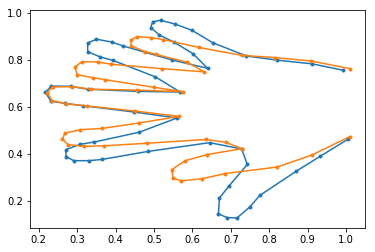

Plot the points for all the hands, so that you can see what a mess it is. You will need to write a loop over the rows of points to plot them all.

Plot the first hand on top (with a line between the points) to see if you can see any structure.

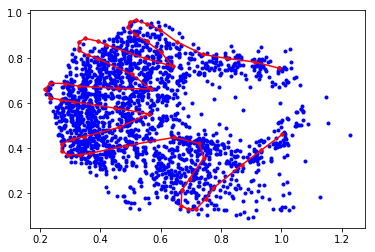

Now use the standardisation from scikit-learn to transform the data and plot it again. You will see that it hasn't made things better. 

Aligning shape data is a bit harder. The way to perform the alignment is called Procrustes alignment. This name comes from Greek mythology. Procrustes was an innkeeper, who claimed the beds in his hotel were the perfect size for everybody. However, to make this true, he changed the person to fit the bed, not the bed to fit the person, stretching them or chopping bits off as necessary. Procrustes alignment does the same thing, without the brutality. 

It does this by rotating, translating, and scaling each set of points so that they are as close as possible to one that we choose as the reference set (the first, for simplicity). We implement this by following a set of steps:

(1) For each hand, move it so that the centroid (middle point) is at the origin by subtracting off the mean in x and y separately. In other words, compute the mean of the x coordinates of each shape, and subtract that from all of them, and the same in y. 
I've made you a new array called newpoints to put the data into. The command to compute the mean is np.mean. It's syntax is np.mean(A,axis=0), which computes the mean of each column of matrix A.

In [15]:
newpoints = np.zeros(np.shape(points))

(2) Scale each hand so that the root mean square distance from the points to the origin is 1. So compute the scale factor as $s = 1/k * \sqrt{(x_1 - \bar{x})^2 + (y_1 - \bar{y})^2 + \ldots + (y_k - \bar{y})^2}$ where there are $k$ points in each hand (so $k=56$). np.sum will help you do the addition. Then divide each of the points by this scale factor.

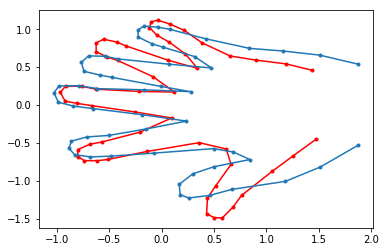

(3) Now rotate each hand from 1 to 40 so that it best lines up with hand 0. This is harder than the others, so I've done it for you. 

In [17]:
for i in range(1,40):
    a = np.sum(newpoints[:,i]* newpoints[:,0])
    b = np.sum(newpoints[:56,i]*newpoints[56:,0] - newpoints[:56,0]*newpoints[56:,i])
    theta = np.arctan2(b , max(a, 10**-10))
    for j in range(56):
        point = np.array([newpoints[j,i],newpoints[j+56,i]])
        x = np.dot(np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]), point)
        newpoints[j,i] = x[0]
        newpoints[j+56,i] = x[1]

Now plot the data again. It's better, but the hand isn't properly lined up yet. 

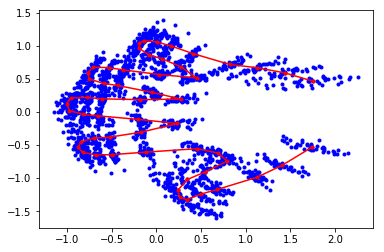

We can make things better, by replacing the points data with newpoints, replacing the first datapoint with the mean, and then running the translation, rotation and scaling again. Run the code below, and then the previous three bits of code again. This time, the plot should look a bit more convincing.

In [14]:
points = newpoints
meanshape = np.mean(newpoints,axis=1)
points[:,0]=meanshape

Below is my code to do PCA. Run it. 

In [36]:
# Compute the covariance matrix
C = np.cov(newpoints)

# Get the eigenvalues and eigenvectors
evals,evecs = np.linalg.eig(C)

# Now need to sort them into descending order
indices = np.argsort(evals)
indices = indices[::-1]
evecs = evecs[:,indices]
evals = evals[indices]
evecs = np.real(evecs)
evals = np.real(evals)

Plot the mean shape (i.e., the shape you get when you just compute the mean of each datapoint across the whole dataset), and also the mean shape plus and minus a small amount in each of the first few PCs (one at a time). See if you can work out what each of them does.

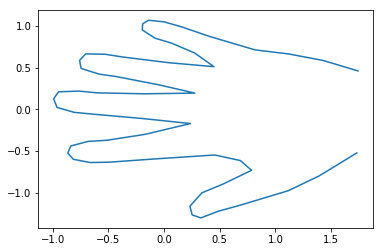

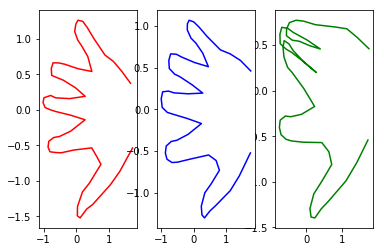

Decide how many principal components you should use by plotting the cumulative sum of the eigenvalues. Explain your answer.